In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim

In [2]:
data_dir = 'D:\cat_dog_data'

transform = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor()])

data_folder = datasets.ImageFolder(data_dir, transform=transform)

data_loader = torch.utils.data.DataLoader(data_folder, batch_size=32, shuffle=True)


In [3]:
test_data_dir = 'D:\cat_dog_train'


transform = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor()])

data_folder = datasets.ImageFolder(test_data_dir, transform=transform)

test_data_loader = torch.utils.data.DataLoader(data_folder, batch_size=32, shuffle=True)



In [4]:
len(test_data_loader)

7

In [5]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
type(data_loader)

torch.utils.data.dataloader.DataLoader

In [7]:
images, labels = next(iter(data_loader))

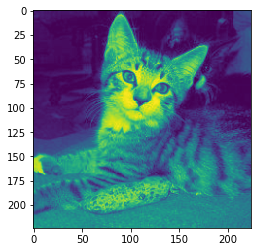

In [8]:
import matplotlib.pyplot as plt
plt.imshow(images[0][1])
plt.show()

In [9]:
print(len(images[0]
         ))

3


In [10]:
images.shape

torch.Size([32, 3, 224, 224])

## Model Building

In [11]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        #Convolution layers
        self.conv1 = nn.Conv2d(3, 16, 3, stride=3)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=3)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=3)
        
        #Max pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        
        #Fully connected layer
        self.fc1 = nn.Linear(64, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 2)
        
        self.drop_out = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        
        x = x.view(-1, 64)
        
        x = self.drop_out(x)
        
        x = F.relu(self.fc1(x))
        
        x = self.drop_out(x)

        x = F.relu(self.fc2(x))
        
        x = self.drop_out(x)

        x = self.fc3(x)
        return x

In [12]:
model = Net()
if train_on_gpu:
    model.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training the network

In [13]:
# number of epochs to train the model
# train_on_gpu = True
import numpy as np

n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in data_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in test_data_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(data_loader.sampler)
    valid_loss = valid_loss/len(test_data_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}\tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'cat_vs_dog_nn.pth')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.695149	Validation Loss: 0.692657
Validation loss decreased (inf --> 0.692657).  Saving model ...
Epoch: 2 	Training Loss: 0.694069	Validation Loss: 0.692939
Epoch: 3 	Training Loss: 0.693440	Validation Loss: 0.691629
Validation loss decreased (0.692657 --> 0.691629).  Saving model ...
Epoch: 4 	Training Loss: 0.695210	Validation Loss: 0.692591
Epoch: 5 	Training Loss: 0.690740	Validation Loss: 0.691577
Validation loss decreased (0.691629 --> 0.691577).  Saving model ...
Epoch: 6 	Training Loss: 0.685576	Validation Loss: 0.687754
Validation loss decreased (0.691577 --> 0.687754).  Saving model ...
Epoch: 7 	Training Loss: 0.673806	Validation Loss: 0.689161
Epoch: 8 	Training Loss: 0.668795	Validation Loss: 0.680853
Validation loss decreased (0.687754 --> 0.680853).  Saving model ...
Epoch: 9 	Training Loss: 0.624895	Validation Loss: 0.760270
Epoch: 10 	Training Loss: 0.608435	Validation Loss: 0.674364
Validation loss decreased (0.680853 --> 0.674364).  Saving 

In [14]:
print("Welldone")

Welldone


In [15]:
# model_s = torch.load('cat_vs_dog_nn.pt')
# model_s.eval()

In [17]:
saved_model = torch.load('cat_vs_dog_nn.pth')

In [18]:
print(saved_model)

OrderedDict([('conv1.weight', tensor([[[[-0.0973,  0.1065,  0.1679],
          [ 0.1972,  0.2064,  0.1733],
          [ 0.1367,  0.1647,  0.0292]],

         [[-0.0004,  0.1351, -0.0036],
          [-0.0421, -0.1359, -0.1214],
          [-0.0592,  0.0731,  0.0006]],

         [[ 0.0222,  0.0541, -0.1040],
          [-0.1149, -0.0990,  0.1131],
          [-0.0852, -0.0195, -0.1779]]],


        [[[-0.0701, -0.1914,  0.1315],
          [-0.0812, -0.1055, -0.1320],
          [ 0.0178,  0.0226, -0.1197]],

         [[-0.1502,  0.0090, -0.1129],
          [-0.1530,  0.0602, -0.0813],
          [-0.0178, -0.1017, -0.0567]],

         [[-0.0730, -0.0618,  0.0646],
          [ 0.0573,  0.1150, -0.0123],
          [ 0.0543, -0.0663,  0.1849]]],


        [[[-0.0924, -0.1603,  0.1079],
          [ 0.1498,  0.1066, -0.0557],
          [-0.0097, -0.0403, -0.0618]],

         [[ 0.1018,  0.1039, -0.0191],
          [ 0.0267,  0.0495, -0.1990],
          [-0.1067, -0.2341, -0.0006]],

         [[-0.

In [41]:


test_transform = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor()])


# def predict_image(image):
#     image_tensor = test_transform(image).float()
#     image_tensor = image_tensor.unsqueeze_(0)
#     input = Variable(image_tensor)
#     input = input.cuda()
#     output = model(input)
#     index = output.data.cpu().numpy().argmax()
#     return index


In [23]:
import os
data_dir = 'D:\practice'
cat_data_dir = os.path.join(data_dir, '0')
print(cat_data_dir)

images = os.listdir(cat_data_dir)
images = images[0:100]
print(len(images))

D:\practice\0
100


In [47]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

test_image_dir = 'D:\practice'
sub_folder = os.path.join(test_image_dir, '0')
full_abs_path = os.path.join(sub_folder, 'cat.1121.jpg')
print(full_abs_path)

D:\practice\0\cat.1121.jpg


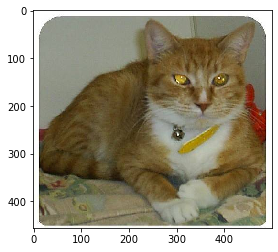

In [48]:
im = Image.open(full_abs_path)
plt.imshow(im)


In [33]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224,224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

In [49]:
test_image = apply_test_transforms(im)

In [50]:
test_image.shape

torch.Size([3, 224, 224])

In [51]:
def predict_image(image):
    image_tensor = apply_test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor.cuda()
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index


In [52]:
predict_image(im)

0